In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import bottleneck
import haversine as hs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygad
from multiprocessing import cpu_count
from os import sched_getaffinity
from collections import Counter
import random 

In [3]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

Generation 1, Best Candidate: [(67.60559238, 2.73282517), (55.5590424, -11.60060323), (63.07102714, -7.10999186), (60.05298464, -10.9971644), (64.35458697, 8.08611287), (61.06438587, -5.72666056), (51.00000105, -9.51450737), (67.36706134, -3.32006865), (61.42027667, -8.94707754), (58.15463402, 3.8419239)], Energy Production: 157.0648025 TWh
Generation 2, Best Candidate: [(54.8857361, 14.01461466), (55.5590424, -11.60060323), (57.74334853, -12.22983453), (60.05298464, -10.9971644), (68.07729247, 1.78828789), (61.06438587, -5.72666056), (51.00000105, -9.51450737), (67.36706134, -3.32006865), (61.42027667, -8.94707754), (58.15463402, 3.8419239)], Energy Production: 159.6685721 TWh
Generation 3, Best Candidate: [(58.23309338, -10.07029627), (55.5590424, -11.60060323), (57.74334853, -12.22983453), (60.05298464, -10.9971644), (68.07729247, 1.78828789), (61.06438587, -5.72666056), (51.00000105, -9.51450737), (67.36706134, -3.32006865), (61.42027667, -8.94707754), (58.15463402, 3.8419239)], En

Generation 25, Best Candidate: [(55.88262884, -12.31449762), (59.13642304, -6.06618264), (57.74334853, -12.22983453), (51.66343148, -11.5991068), (60.35895709, -3.79654276), (57.32262233, 3.26509709), (56.37306579, -8.50630002), (52.88791793, -11.76862659), (56.93888486, 6.72946046), (56.97591566, 5.91124173)], Energy Production: 167.8368285 TWh
Generation 26, Best Candidate: [(55.88262884, -12.31449762), (58.21685678, -11.05403096), (57.74334853, -12.22983453), (51.66343148, -11.5991068), (60.35895709, -3.79654276), (56.13457972, 1.65298422), (56.37306579, -8.50630002), (52.88791793, -11.76862659), (56.93888486, 6.72946046), (56.97591566, 5.91124173)], Energy Production: 167.9943867 TWh
Generation 27, Best Candidate: [(55.88262884, -12.31449762), (58.21685678, -11.05403096), (57.74334853, -12.22983453), (57.17259726, -9.42339482), (60.35895709, -3.79654276), (56.13457972, 1.65298422), (56.37306579, -8.50630002), (52.88791793, -11.76862659), (56.93888486, 6.72946046), (56.97591566, 5.9

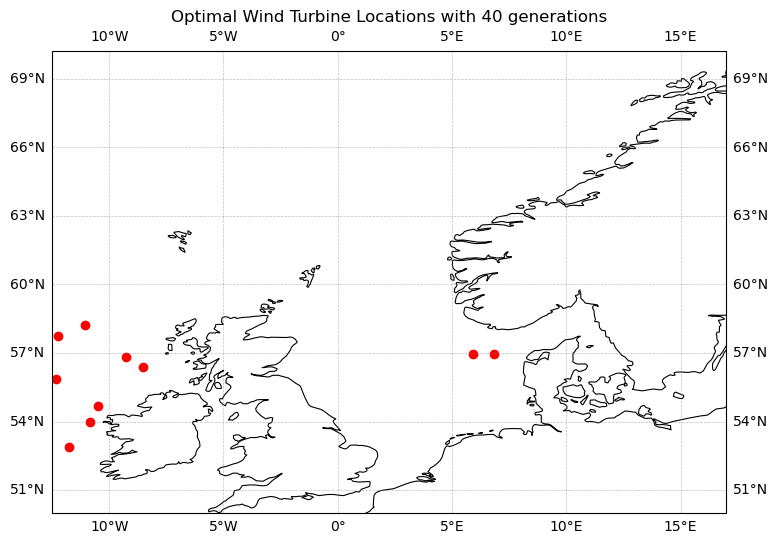

In [6]:
# Load the dataset
paths = ["/share/data1/xzcaplbl/100m_1982_to_2022_8.3MW.nc"]
ds = xr.open_mfdataset(paths, concat_dim='time', data_vars='minimal', combine='nested', coords='minimal', compat='override')

# Extract relevant power data (assuming 'power' is the variable in your dataset)
power_data = ds['power']

# Define the latitude and longitude limits
latitude_limits = (50, 70)
longitude_limits = (-12.5, 17)

# Define the problem parameters
num_wind_farms = 10
mutation_rate = 0.1
generations = 40
population_size = 50
transmission_location = (52.776584171224556, -1.5821643532504668) 
demand_center  =(52.776584171224556, -1.5821643532504668) 
transmission_loss_factor = 0.01
time_duration = 350400  # Include time_duration here
turbines_per_grid = 385.25/1.075648

def generate_random_solution(num_wind_farms, latitude_limits, longitude_limits):
    return [(random.uniform(*latitude_limits), random.uniform(*longitude_limits)) for _ in range(num_wind_farms)]

def fitness(solution, power_data, transmission_location,transmission_loss_factor, time_duration, turbines_per_grid):
    # Your function implementation here
    total_energy_production = 0

    for i, position in enumerate(solution):
        x, y = position
        power_at_location = power_data.sel(latitude=x, longitude=y, method='nearest').values

        if isinstance(power_at_location, np.ndarray):
            # Handle the case where power_at_location is an array
            distance_to_demand_center = haversine_distance(x, y, demand_center[0], demand_center[1])
            transmission_loss = 1 - (distance_to_demand_center * transmission_loss_factor / 100)

            # Calculate energy production considering the number of turbines
            total_energy_production += np.mean(power_at_location) * transmission_loss * time_duration * turbines_per_grid

        else:
            distance_to_demand_center = haversine_distance(x, y, demand_center[0], demand_center[1])
            transmission_loss = 1 - (distance_to_demand_center * transmission_loss_factor / 100)

            # Calculate energy production considering the number of turbines
            total_energy_production += power_at_location * transmission_loss * time_duration * turbines_per_grid

    # Calculate average production over 40 years
    total_energy_production_per_year = total_energy_production / 40

    # Convert to TWh
    total_energy_Thw = total_energy_production_per_year / 1_000_000_000

    return total_energy_Thw


# Function to perform crossover between two solutions
def crossover(parent1, parent2):
    crossover_point = random.randint(0, num_wind_farms - 1)
    child = parent1[:crossover_point] + parent2[crossover_point:]
    return child

# Function to perform mutation on a solution
def mutate(solution, mutation_rate, latitude_limits, longitude_limits):
    mutated_solution = []
    for position in solution:
        if random.random() < mutation_rate:
            mutated_solution.append((random.uniform(*latitude_limits), random.uniform(*longitude_limits)))
        else:
            mutated_solution.append(position)
    return mutated_solution

def genetic_algorithm(num_wind_farms, power_data, mutation_rate, generations, demand_center, transmission_loss_factor, time_duration, turbines_per_grid):
    current_population = [generate_random_solution(num_wind_farms, latitude_limits, longitude_limits) for _ in range(population_size)]
    best_candidates_history = []

    for generation in range(generations):
        # Evaluate fitness of each individual in the population
        
        fitness_scores = [fitness(candidate, power_data, demand_center, transmission_loss_factor, time_duration, turbines_per_grid) for candidate in current_population]

        # Select parents for crossover based on fitness
        parents = [current_population[i] for i in np.argsort(fitness_scores)[-2:]]

        # Generate new population through crossover and mutation
        new_population = [crossover(parents[0], parents[1]) for _ in range(population_size)]
        new_population = [mutate(candidate, mutation_rate, latitude_limits, longitude_limits) for candidate in new_population]

        # Replace the old population with the new population
        current_population = new_population

        # Store the best candidate in the current generation
        best_candidate = max(current_population, key=lambda x: fitness(x, power_data, demand_center, transmission_loss_factor, time_duration, turbines_per_grid))
        best_candidates_history.append(best_candidate)

        # Print information about the best candidate in the current generation
        best_energy_production = fitness(best_candidate, power_data, demand_center, transmission_loss_factor, time_duration, turbines_per_grid)
        print(f"Generation {generation + 1}, Best Candidate: {[(round(coord[0], 8), round(coord[1], 8)) for coord in best_candidate]}, Energy Production: {round(best_energy_production, 7)} TWh")

    return best_candidates_history

best_candidates_history = genetic_algorithm(num_wind_farms, power_data, mutation_rate, generations, transmission_location, transmission_loss_factor, time_duration, turbines_per_grid)

 
# Extract the optimal candidate from the last generation
optimal_turbine_locations = best_candidates_history[-1]

# Create a map with coastlines and wind speed overlay
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12.5, 17, 50, 70])

# Add coastlines with the cartopy.feature module
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot the optimal turbine locations
lats, lons = zip(*optimal_turbine_locations)
ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree())

# Set the title
plt.title('Optimal Wind Turbine Locations with 40 generations')
plt.grid()

# Show the plot
plt.show()